<h2>Kernel SVM</h2>

<p>This project implements a kernelized SVM (support vector machine).</p>

<h3>Python Initialization</h3>

In [1]:
import sys
import time
import numpy as np
from numpy.matlib import repmat

from scipy.stats import linregress
import scipy.optimize as so

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

print('Running python %s' % sys.version.split(' ')[0])

Running python 3.8.9


### Generate and Visualize Data

Before we start, let's generate some data and visualize the training set.

In [2]:
def generate_data(n=100):
    # Sample data from Gaussian distribution N(0, 1)
    X_train = np.random.randn(n, 2)
    y_train = np.ones(n, dtype=np.int)
    
    # the first half the data is sampled from N([5,5], 1)
    X_train[:n // 2] += 5
    # the second half the data is sampled from N([10,10], 1)
    X_train[n // 2:] += 10
    y_train[n // 2:] = -1
    
    return X_train, y_train

In [3]:
def visualize_2D(X_train, y_train):
    """
    This function visualizes the 2D dataset.
    
    Inputs:
    ------
    X_train : training features
    y_train : training labels
    
    Outputs:
    -------
    None : plots a figure
    """
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(y_train)
    
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c,0], X_train[y_train == c,1], marker=marker_symbols[idx], label=str(c))
        
    plt.legend(loc=2)
    plt.show()

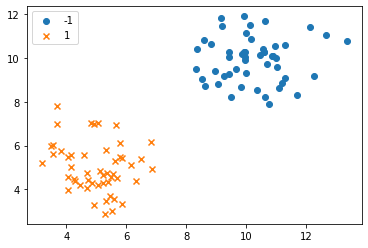

In [4]:
X_train, y_train = generate_data()
visualize_2D(X_train, y_train)

### Part One: Compute K

In <code>computeK</code>, we calculate the values of different kernel functions given inputs `X` and `Z`. It will return $K = K(X,Z)$. $K_{ij} = k(\mathbf x_i, \mathbf z_j)$ where $k( \mathbf x_i, \mathbf z_j) = \phi(\mathbf x_i)^T\phi(\mathbf z_j)$. This function takes in the parameter `kerneltype` to decide which of the three different kernel functions to evaluate. To review, recall the following types of kernels:

- Linear: $K(X,Z) = X^TZ$
- Polynomial: $K(X, Z)=\left(X^{T} Z+1\right)^{d}$ where `kpar` = $d$
- RBF: $K(X,Z) = \exp\{-\frac{||X-Z||^2}{\sigma^2}\}$ where `kpar` = $\frac{1}{\sigma^2}$

In [5]:
def l2distance(X, Z=None):
    """
    function D=l2distance(X,Z)
    
    This function computes the Euclidean distance matrix.
    
    Syntax:
    ------
    D = l2distance(X,Z)
    
    Inputs:
    ------
    X : dxn data matrix with n vectors (columns) of dimensionality d
    Z : dxm data matrix with m vectors (columns) of dimensionality d
    
    Outputs:
    -------
    Matrix D of size nxm
    D(i,j) is the Euclidean distance of X(:,i) and Z(:,j)
    
    This function can be called with only one input:
    l2distance(X) = l2distance(X,X)
    """
    if Z is None:
        n, d = X.shape
        s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        D1 = -2 * np.dot(X, X.T) + repmat(s1, 1, n)
        D = D1 + repmat(s1.T, n, 1)
        np.fill_diagonal(D, 0)
        D = np.sqrt(np.maximum(D, 0))
    else:
        n, d = X.shape
        m, _ = Z.shape
        s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
        s2 = np.sum(np.power(Z, 2), axis=1).reshape(1,-1)
        D1 = -2 * np.dot(X, Z.T) + repmat(s1, 1, m)
        D = D1 + repmat(s2, n, 1)
        D = np.sqrt(np.maximum(D, 0))
        
    return D

In [6]:
def computeK(kerneltype, X, Z, kpar=1):
    """
    function K = computeK(kernel_type, X, Z)
    
    This function computes a matrix K such that Kij = k(x,z);
    for three different functions: linear, rbf or polynomial.
    
    Inputs:
    ------
    kerneltype : either 'linear', 'polynomial', 'rbf'
    X          : n input vectors of dimension d (nxd)
    Z          : m input vectors of dimension d (mxd)
    kpar       : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    Outputs:
    -------
    K : nxm kernel matrix
    """
    assert kerneltype in ['linear', 'polynomial', 'rbf'], 'Kernel type %s not known.' % kerneltype
    assert X.shape[1] == Z.shape[1], 'Input dimensions do not match'
    
    if kerneltype == 'linear':
        K = np.dot(X, Z.T)
    elif kerneltype == 'polynomial':
        K = np.power((np.dot(X, Z.T) + 1), kpar)
    elif kerneltype == 'rbf':
        K = np.exp(-kpar * np.square(l2distance(X, Z)))
    else:
        raise ValueError('Invalid kernel type. Try again.')
        
    return K

### Part Two: Compute Loss

Now, we are going to implement the function <code>loss</code>. In the kernelized version of the loss, $\mathbf{w}$ is calculated as a linear combination of the training examples, so we need to pass the training set to the function.

The following is an explanation of the theory that leads us to the loss expression.

Recall that we can express the solution as a linear combination of the training examples

$\{\phi(\mathbf{x}_1), \cdots, \phi(\mathbf{x}_n) \}$:

$$
\begin{aligned}
\mathbf{w} = \sum_{j = 1}^n \alpha_j y_j \phi(\mathbf{x}_j)
\end{aligned}
$$

To simplify, we define $\beta_j = \alpha_j y_j$ and we can express the solution as:
$$
\begin{aligned}
\mathbf{w} = \sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)
\end{aligned}
$$

If we substitute the formulation above into our unconstrained regularized squared hinge loss,
$$
\begin{aligned}
\min_{\mathbf{w},b}\underbrace{\mathbf{w}^T\mathbf{w}}_{l_{2} \text{ regularizer} } +  C\
\sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{w}^T \mathbf{x}_i+b),0 \right ] ^2}_{ \text{squared hinge loss} }
\end{aligned}
$$

we obtain:
$$
\begin{aligned}
\underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i  \beta_j \phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}     
\end{aligned}
$$

Now, if we replace all the $\phi(\mathbf{x} _i)^T \phi(\mathbf{x}_j)$ with $k(\mathbf{x}_i, \mathbf{x}_j)$, we obtained the "kernelized" hinge loss.

$$
\begin{aligned}
\min_{\beta_1,\cdots,\beta_n, b} \underbrace{\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j)}_{l_{2} \text{ regularizer}} +  C\  \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\sum_{j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i)+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$

The expression above seems a little bit unwieldy, so we are going to simplify the expression again. First, we will simplify the $l_{2}$ regularizer. Define $\mathbf{\beta} = [\beta_1, \cdots, \beta_n]^T$ and $K_{train}$ to be the kernel matrix calculated on the training set, namely, the (i, j)-th entry of $K_{train}$ is $k(\mathbf{x} _i, \mathbf{x}_j)$. It is easy to verify that the $l_{2}$ regularizer can be expressed as the quadratic form

$$
\sum_{i = 1} ^n \sum_{j = 1}^n \beta_i \beta_j k(\mathbf{x} _i, \mathbf{x}_j) = \mathbf{\beta}^T K_{train} \mathbf{\beta}
$$

Now, let's simplify the squared hinge loss. To start, we define $K_{train}[i]$ as the i-th row of $k_{train}$ expressed as a column vector. Now, the summation term within the hinge loss can be expressed as:

$$
\sum_{ j = 1}^n \beta_j k(\mathbf{x}_j, \mathbf{x}_i) = \mathbf{\beta}^T K_{train}[i]
$$

Combining the two simplifications we have, we arrive at the following expression for the loss function: 
$$
\begin{aligned}
\min_{\mathbf{\beta}, b} \underbrace{\mathbf{\beta}^T K_{train} \mathbf{\beta}}_{l_{2}  \text{ regularizer}} +  C\ \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{\beta}^T K_{train}[i]+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$

After we minimize this expression and have found a good $\beta$ that works on the kernel generated from the training data, $K_{train}$, we can test using our $\beta$ and calculating the loss against testing data: 

$$
\begin{aligned}
\min_{\mathbf{\beta}, b} \underbrace{\mathbf{\beta}^T K_{train} \mathbf{\beta}}_{l_{2}  \text{ regularizer}} +  C\ \sum_{i=1}^{n}\underbrace{\max\left [ 1-y_{i}(\mathbf{\beta}^T K_{test}[i]+b),0 \right ] ^ 2}_{\text{squared hinge loss}}
\end{aligned}
$$

Note that the loss function we have above is very similar to the vanilla linear SVM, the differences are: 

1. Instead of $\mathbf{w}$, we have $\mathbf{\beta}$
2. The $l_{2}$ regularizer $\mathbf{w}^T \mathbf{w} = \mathbf{w}^T I \mathbf{w}$ is changed to $\mathbf{\beta}^T K_{train} \mathbf{\beta}$ to account for using $\mathbf{\beta}$ instead of $\mathbf{w}$
3. The inner product $\mathbf{w}^T \mathbf{x}_i$ in the hinge loss is changed to $\mathbf{\beta}^T K_{train}[i]$

This is useful because we never need to explicitly calculate $\phi(\mathbf x_i)$, which can be exponential in size, or in the case of RBF, have an infinite number of elements. On the other hand, $K$ will be a $m x n$ matrices that encapsulates all the data you would gain from $\phi$.

Note that in the following code we are passing in both training data (`X_train`, `y_train`) and testing data (`X_test`, `y_test`) to calculate two kernels, `kernel_train` and `kernel_test` respectively. Unfortunately, when we're training an algorithm, we don't have access to test data! That would make the test data a very poor evaluator of the performance of the algorithm. This function is written so that passing **training data** into the parameters `X_test` and `y_test` will train the SVM on training data to find the best betas. During testing, passing in **test data** into those variables can be used to evaluate how good your algorithm is.

In [7]:
def loss(beta, b, X_train, y_train, X_test, y_test, C, kerneltype, kpar=1):
    """
    Inputs:
    ------
    beta       : n dimensional vector that stores the linear combination coefficient
    X_train    : nxd dimensional matrix (training set, each row is an input vector)
    y_train    : n dimensional vector (training label, each entry is a label)
    b          : scalar (bias)
    X_test     : mxd dimensional matrix (test set, each row is an input vector)
    y_test     : m dimensional vector (test label, each entry is a label)
    C          : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype : either 'linear', 'polynomial', 'rbf'
    kpar       : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    Outputs:
    -------
    loss : the total loss obtained with (beta, X_test, y_test, b) on X_test and y_test (scalar)
    """
    # compute the kernel values between X_train and X_train
    kernel_train = computeK(kerneltype, X_train, X_train, kpar)
    
    # compute the kernel values between X_test and X_train
    kernel_test = computeK(kerneltype, X_test, X_train, kpar)
    
    prediction = kernel_test @ beta + b
    margin = y_test * prediction
    loss_val = beta @ kernel_test @ beta + C * (np.sum(np.power(np.maximum(1 - margin, 0), 2)))
    
    return loss_val

### Part Three: Compute Gradient

Now, we implement function `grad`, that computes the gradient of the loss function. This function has the same input parameters as `loss` and requires the gradient with respect to $\beta$ (`beta_grad`) and $b$ (`bgrad`). Remember that the squared hinge loss is calculated with $K_{train}$ when training, and $K_{test}$ when testing. In the code, we can represent this by using the variables associated with testing (i.e. `X_test`, `y_test`, and `k_test`), since they will contain training data if you are training the SVM.

Recall the expression for loss from above. First we take the derivative with respect to $\beta$:
$$
\frac{\partial \mathcal L}{\partial \mathbf \beta} =  2{K_{train} \mathbf{\beta}} +  C\
\sum_{i=1}^{n}{ 2 \max\left [ 1-y_{i}(\mathbf{\beta}^T K_{test}[i]+b),0 \right ] (-y_i K_{test}[i])}
$$

Then, with respect to $b$:
$$
\frac{\partial \mathcal L}{\delta b} =  C\  \sum_{i=1}^{n}{ 2 \max\left [ 1-y_{i}(\mathbf{\beta}^T K_{test}[i]+b),0 \right ] (-y_i)}
$$

In [8]:
def grad(beta, b, X_train, y_train, X_test, y_test, C, kerneltype, kpar=1):
    """
    Inputs:
    ------
    beta       : n dimensional vector that stores the linear combination coefficient
    X_train    : nxd dimensional matrix (training set, each row is an input vector)
    y_train    : n dimensional vector (training label, each entry is a label)
    b          : scalar (bias)
    X_test     : mxd dimensional matrix (test set, each row is an input vector)
    y_test     : m dimensional vector (test label, each entry is a label)
    C          : scalar (constant that controls the tradeoff between l2-regularizer and hinge-loss)
    kerneltype : either 'linear', 'polynomial', 'rbf'
    kpar       : kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    Outputs:
    -------
    beta_grad : n dimensional vector (the gradient of the hinge loss with respect to the alphas)
    bgrad     : constant (the gradient of he hinge loss with respect to the bias, b)
    """
    # compute the kernel values between X_train and X_train 
    kernel_train = computeK(kerneltype, X_train, X_train, kpar)
    
    # compute the kernel values between X_test and X_train
    kernel_test = computeK(kerneltype, X_test, X_train, kpar)
    
    # prediction = kernel_test @ beta + b
    margin = y_test * (kernel_test @ beta + b)
    hinge = np.maximum(1 - margin, 0)
    beta_grad = 2 * (kernel_test @ beta) + C * np.sum((2 * hinge * -y_test).reshape(-1, 1) * kernel_test, axis=0)
    bgrad = C * np.sum(2 * hinge * -y_test, axis=0)
    
    return beta_grad, bgrad

## Test the Kernelized Algorithm

Using the cell below, we can call the optimization routine to see the final loss of our model.

In [9]:
def minimize(objective, grad, X_train, y_train, C, kerneltype, kpar):
    
    def loss_lambda(X):
        return objective(X[:-1], X[-1], X_train, y_train, X_train, y_train, C, kerneltype, kpar)
    
    def grad_lambda(X):
        return np.append(*grad(X[:-1], X[-1], X_train, y_train, X_train, y_train, C, kerneltype, kpar))
    
    n, d = X_train.shape
    alpha = np.zeros(n)
    b = np.zeros(1)
    
    init = np.append(alpha, np.array(b))
    sol = so.minimize(loss_lambda, x0=init, jac=grad_lambda, method='SLSQP', options={'ftol': 1e-8, 'maxiter': 10000})
    alpha = sol.x[:-1]
    b = sol.x[-1]
    
    return alpha, b, sol.fun

In [10]:
beta_sol, bias_sol, final_loss = minimize(objective=loss, grad=grad, X_train=X_train,
                                          y_train=y_train, C=1000, kerneltype='linear', kpar=1)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss))

The Final Loss of your model is: 0.4048


If everything is implemented correctly, we should be able to get a training error of zero when we run the following cell.

In [11]:
svmclassify = lambda x: np.sign(computeK('linear', x, X_train, 1).dot(beta_sol) + bias_sol)

train_predictions = svmclassify(X_train)
training_error = np.mean(np.sign(train_predictions) != y_train)
print('Training error: %2.4f' % training_error)

Training error: 0.0000


<h3>Visualize the Decision Boundary</h3>

Also, when we visualize the classifier, we should see a max margin separator.

In [12]:
def visclassifier(fun, X_train, y_train):
    """
    This function is used to visualize decision boundary.
    
    Inputs:
    ------
    fun     : classifier function
    X_train : training features
    y_train : training labels
    
    Outputs:
    -------
    None : a figure is returned to the screen
    """
    y_train = np.array(y_train).flatten()
    
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    classvals = np.unique(y_train)
    
    plt.figure()
    
    res = 300
    xrange = np.linspace(min(X_train[:,0]), max(X_train[:,0]), res)
    yrange = np.linspace(min(X_train[:,1]), max(X_train[:,1]), res)
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    
    X_test = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    testpreds = fun(X_test)
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c,0], X_train[y_train == c,1], marker=marker_symbols[idx], color='k')
        
    plt.axis('tight')
    plt.show()

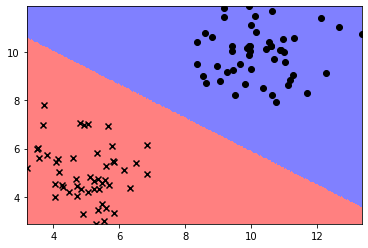

In [13]:
visclassifier(svmclassify, X_train, y_train)

Let's visualize a different kind of nonlinear data, a spiral dataset.

In [14]:
def spiraldata(N=300):
    r = np.linspace(1, 2 * np.pi, N)
    X_train1 = np.array([np.sin(2 * r) * r, np.cos(2 * r) * r]).T
    X_train2 = np.array([np.sin(2 * r + np.pi) * r, np.cos(2 * r + np.pi) * r]).T
    X_train = np.concatenate([X_train1, X_train2], axis=0)
    y_train = np.concatenate([np.ones(N), -1 * np.ones(N)])
    X_train = X_train + np.random.randn(X_train.shape[0], X_train.shape[1]) * 0.2
    
    X_test = X_train[::2,:]
    y_test = y_train[::2]
    X_train = X_train[1::2,:]
    y_train = y_train[1::2]
    
    return X_train, y_train, X_test, y_test

In [15]:
def visualize_2D(X_train, y_train):
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='b')
    plt.scatter(X_train[y_train != 1, 0], X_train[y_train != 1, 1], c='r')
    plt.legend(['+1', '-1'])
    plt.show()

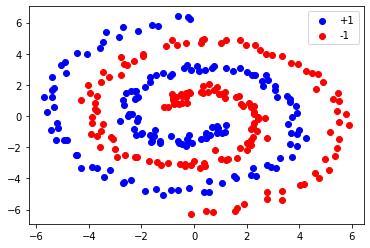

In [16]:
X_train_spiral, y_train_spiral, X_test_spiral, y_test_spiral = spiraldata()
visualize_2D(X_train_spiral, y_train_spiral)

Since the dataset is nonlinear, we are going to use the rbf kernel.

In [17]:
beta_sol_spiral, bias_sol_spiral, final_loss_spiral = minimize(objective=loss, grad=grad, X_train=X_train_spiral, 
                                                               y_train=y_train_spiral, C=100, kerneltype='rbf', kpar=1)
print('The Final Loss of your model is: {:0.4f}'.format(final_loss_spiral))

The Final Loss of your model is: 72.1477


If we do everything correctly, our training error and test error should both be zero!

In [18]:
svmclassify_spiral = lambda x: np.sign(computeK('rbf', X_train_spiral, x, 1).transpose().dot(beta_sol_spiral) + bias_sol_spiral)

train_predictions_spiral = svmclassify_spiral(X_train_spiral)
training_error_spiral = np.mean(train_predictions_spiral != y_train_spiral)
print('Training error: %2.4f' % training_error_spiral)

test_predictions_spiral = svmclassify_spiral(X_test_spiral)
test_error_spiral = np.mean(test_predictions_spiral != y_test_spiral)
print('Test error: %2.4f' % test_error_spiral)

Training error: 0.0000
Test error: 0.0000


Now, let's visualize the classifier on the spiral dataset!

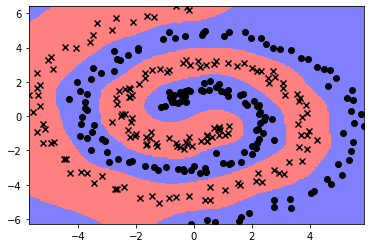

In [19]:
visclassifier(svmclassify_spiral, X_train_spiral, y_train_spiral)